<a href="https://colab.research.google.com/github/pNTubil/CALC-LD/blob/main/mbertt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
##################################
# Install Necessary Libraries
##################################
!pip install transformers datasets torch scikit-learn tokenizers sentencepiece

##################################
# Necessary Imports
##################################
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import PreTrainedTokenizerFast
from tokenizers import SentencePieceBPETokenizer

##################################
# Load the Preprocessed Dataset
##################################
file_path = "/content/bxlm_roberta_ambiguous_word_labeled10k.csv"
labeled_reviews = pd.read_csv(file_path)

##################################
# Stratified Splitting (80-10-10)
##################################
train_df, temp_df = train_test_split(
    labeled_reviews,
    test_size=0.2,
    stratify=labeled_reviews["label"],
    random_state=42
)  # 80% train

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=42
)  # 10% validation, 10% test

##################################
# Train Custom SentencePiece Tokenizer
##################################
# Create a corpus file from the training reviews
corpus_path = "/content/reviews_corpus.txt"
with open(corpus_path, "w", encoding="utf-8") as f:
    for review in train_df["review"]:
        f.write(review.strip() + "\n")
print(f"Corpus file created at {corpus_path}")

# Initialize and train the SentencePiece tokenizer
sp_tokenizer = SentencePieceBPETokenizer()
sp_tokenizer.train(files=[corpus_path], vocab_size=2000, min_frequency=2)

# Save the tokenizer files to a directory with a chosen prefix
tokenizer_dir = "/content/mbert_sentencepiece"
os.makedirs(tokenizer_dir, exist_ok=True)
sp_tokenizer.save_model(tokenizer_dir, "tokenizer")  # Use positional argument for prefix
print(f"Custom SentencePiece tokenizer trained and saved at {tokenizer_dir}")

# Additionally, save a combined tokenizer.json file for PreTrainedTokenizerFast
with open(f"{tokenizer_dir}/tokenizer.json", "w", encoding="utf-8") as f:
    f.write(sp_tokenizer.to_str())
print("tokenizer.json file created.")

##################################
# Load the Custom Tokenizer as a Fast Tokenizer
##################################
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    tokenizer_dir,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]"
)
print("✅ Custom SentencePiece tokenizer loaded successfully!")

##################################
# Define a Function to Tokenize Reviews
##################################
def tokenize_reviews(reviews, tokenizer, max_length=128):
    tokenized_texts = []
    for text in reviews:
        encodings = tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt"
        )
        tokenized_texts.append({
            "input_ids": encodings["input_ids"].squeeze().tolist(),
            "attention_mask": encodings["attention_mask"].squeeze().tolist()
        })
    return tokenized_texts

##################################
# Tokenize Each Split
##################################
train_df["tokenized"] = tokenize_reviews(train_df["review"].tolist(), tokenizer)
val_df["tokenized"] = tokenize_reviews(val_df["review"].tolist(), tokenizer)
test_df["tokenized"] = tokenize_reviews(test_df["review"].tolist(), tokenizer)

##################################
# Save the Train, Validation, and Test Splits
##################################
train_output_path = "/content/train_preprocessed10knew.csv"
val_output_path = "/content/val_preprocessed10knew.csv"
test_output_path = "/content/test_preprocessed10knew.csv"

train_df.to_csv(train_output_path, index=False)
val_df.to_csv(val_output_path, index=False)
test_df.to_csv(test_output_path, index=False)

##################################
# Confirmation Message
##################################
print(f"✅ Train dataset saved to: {train_output_path}")
print(f"✅ Validation dataset saved to: {val_output_path}")
print(f"✅ Test dataset saved to: {test_output_path}")

##################################
# Display Sample Data
##################################
print("📊 Sample of Preprocessed Data:")
print(train_df[["review", "label"]].head())


Corpus file created at /content/reviews_corpus.txt
Custom SentencePiece tokenizer trained and saved at /content/mbert_sentencepiece
tokenizer.json file created.


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


✅ Custom SentencePiece tokenizer loaded successfully!
✅ Train dataset saved to: /content/train_preprocessed10knew.csv
✅ Validation dataset saved to: /content/val_preprocessed10knew.csv
✅ Test dataset saved to: /content/test_preprocessed10knew.csv
📊 Sample of Preprocessed Data:
                                                  review  label
8576   good quality comfortable to wear cheap price m...      1
5649   maganda sya guys.. bili na kayoo. i'm so glad ...      0
2074   effective magandang araw matagal kona na tangg...      1
563    hindi ok ung tela ito ung mainit eh look at th...      1
10133  game mode,bass napaka ganda ng bass nya at noi...      1


In [5]:
##################################
# Install Necessary Libraries
##################################
!pip install transformers datasets torch scikit-learn

##################################
# Necessary Imports
##################################
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import (
    PreTrainedTokenizerFast,  # For loading the custom SentencePiece tokenizer
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.metrics import precision_recall_fscore_support
import os

##################################
# Disable W&B Logging
##################################
os.environ["WANDB_DISABLED"] = "true"  # Prevents W&B from asking for API key

##################################
# Dynamically Set Device (GPU if available)
##################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

##################################
# Load Preprocessed Train & Validation Dataset
##################################
train_df = pd.read_csv("/content/train_preprocessed10knew.csv")
val_df = pd.read_csv("/content/val_preprocessed10knew.csv")

##################################
# Load Custom SentencePiece mBERT Tokenizer
##################################
# This assumes your custom SentencePiece tokenizer is saved in /content/mbert_sentencepiece/
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    "/content/mbert_sentencepiece",
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]"
)
print("✅ Custom SentencePiece tokenizer loaded successfully!")

##################################
# Define Custom Dataset Class
##################################
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encodings["input_ids"].squeeze(),
            "attention_mask": encodings["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

##################################
# Create Train & Validation Datasets
##################################
train_dataset = ReviewDataset(train_df["review"], train_df["label"], tokenizer)
val_dataset = ReviewDataset(val_df["review"], val_df["label"], tokenizer)

##################################
# Load Pretrained mBERT Model
##################################
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=2  # Binary classification
)
model.to(device)  # Move model to GPU if available

##################################
# Define Evaluation Metrics (Only Precision & F1)
##################################
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1)
    precision, _, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="weighted"
    )
    return {"precision": precision, "f1": f1}

##################################
# Training Arguments Configuration
##################################
training_args = TrainingArguments(
    output_dir="./mbert_results",
    evaluation_strategy="epoch",      # Evaluate at the end of each epoch
    save_strategy="epoch",
    save_total_limit=1,               # Save only the best checkpoint
    logging_dir="./logs_mbert",
    logging_steps=50,
    per_device_train_batch_size=8,    # Adjust based on GPU memory
    per_device_eval_batch_size=8,
    num_train_epochs=10,              # Training for 10 epochs
    learning_rate=2e-5,               # Lower learning rate for slower, steadier convergence
    weight_decay=0.02,                # Increased weight decay for better regularization
    fp16=False,                     # Set True if your GPU supports mixed precision
    gradient_accumulation_steps=2,    # Lower accumulation steps for a smaller effective batch size
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)

##################################
# Initialize Trainer with Early Stopping Callback
##################################
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

##################################
# Train the Model (Using GPU if available)
##################################
trainer.train()

##################################
# Save the Best Model
##################################
trainer.save_model("./mbert_results/best_model")
print("✅ Training complete. Best mBERT model saved to './mbert_results/best_model'")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


Using device: cuda
✅ Custom SentencePiece tokenizer loaded successfully!


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Precision,F1
1,0.350600,0.290473,0.894047,0.886992
2,0.269600,0.229104,0.926021,0.925767
3,0.126500,0.206521,0.950671,0.947227
4,0.111700,0.211185,0.960029,0.959281
5,0.067200,0.192491,0.968081,0.968077
6,0.059700,0.165724,0.972908,0.972864
7,0.047000,0.167983,0.968081,0.968076
8,0.026700,0.162221,0.973693,0.973663
9,0.033700,0.187497,0.969677,0.969673
10,0.016800,0.182179,0.972068,0.972067


✅ Training complete. Best mBERT model saved to './mbert_results/best_model'


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


✅ Custom SentencePiece tokenizer loaded successfully for testing!


Precision: 0.9871
F1-Score: 0.9824
ROC-AUC: 0.9914


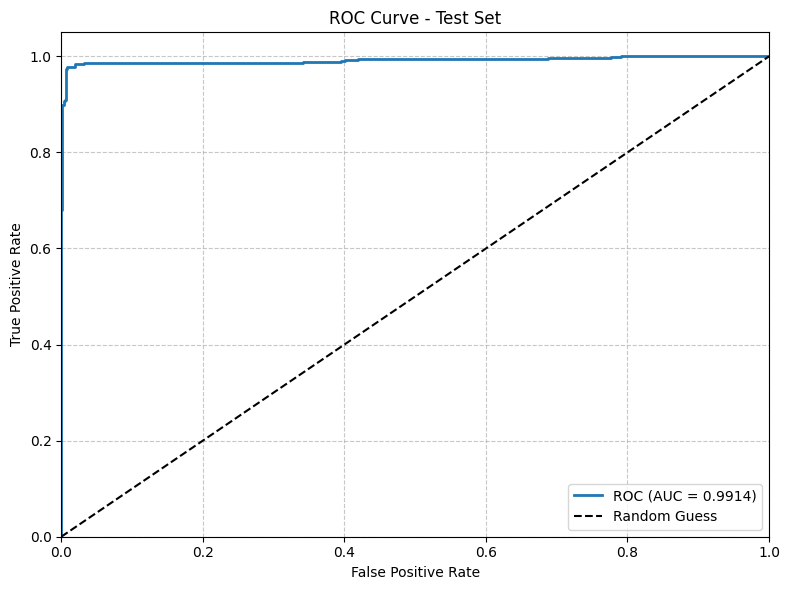

In [7]:
############################################
# Necessary Imports
############################################
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import (
    PreTrainedTokenizerFast,  # Load our custom SentencePiece tokenizer
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

############################################
# 1. Load Test Data
############################################
test_df = pd.read_csv('/content/test_preprocessed10knew.csv')

# Load the custom SentencePiece tokenizer for mBERT from our saved directory.
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    "/content/mbert_sentencepiece",
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]"
)
print("✅ Custom SentencePiece tokenizer loaded successfully for testing!")

############################################
# 2. Dataset Class
############################################
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist()  # Ensure it's a list
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encodings['input_ids'].squeeze(),
            'attention_mask': encodings['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create the test dataset.
test_dataset = ReviewDataset(test_df['review'], test_df['label'], tokenizer)

############################################
# 3. Compute Metrics & Plotting Functions
############################################
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits_tensor = torch.tensor(logits)
    predictions = torch.argmax(logits_tensor, dim=1).numpy()
    probs = torch.nn.functional.softmax(logits_tensor, dim=1)[:, 1].detach().numpy()

    # Compute metrics: precision, F1-score (binary), and ROC-AUC.
    precision, _, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    roc_auc = roc_auc_score(labels, probs)

    return {
        "precision": precision,
        "f1": f1,
        "roc_auc": roc_auc
    }

def plot_roc_curve(labels, probs, title):
    fpr, tpr, _ = roc_curve(labels, probs)
    auc_score = roc_auc_score(labels, probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {auc_score:.4f})", linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

############################################
# 4. Load Trained (Best) Model
############################################
best_model_path = "/content/mbert_results/best_model"
model = BertForSequenceClassification.from_pretrained(best_model_path, num_labels=2)

training_args = TrainingArguments(
    output_dir="/content/mbert_results",
    per_device_eval_batch_size=8,
    logging_dir="/content/logs_mbert"
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

############################################
# 5. Evaluate on Test Set
############################################
test_results = trainer.predict(test_dataset)
metrics = compute_metrics((test_results.predictions, test_results.label_ids))

# Print selected metrics.
print(f"Precision: {metrics['precision']:.4f}")
print(f"F1-Score: {metrics['f1']:.4f}")
print(f"ROC-AUC: {metrics['roc_auc']:.4f}")

# Compute probabilities correctly.
logits = torch.tensor(test_results.predictions)
probs = torch.nn.functional.softmax(logits, dim=1)[:, 1].detach().numpy()

# Plot ROC curve.
plot_roc_curve(test_results.label_ids, probs, "ROC Curve - Test Set")
